# Sampling process of marked Hawkes process

In [1]:
using CSV,DataFrames,Distributions,NLsolve,Plots,Parameters,QuadGK,SpecialFunctions,StatsBase

## 1. The probability mass function (PMF) for event size $\rho(m)$

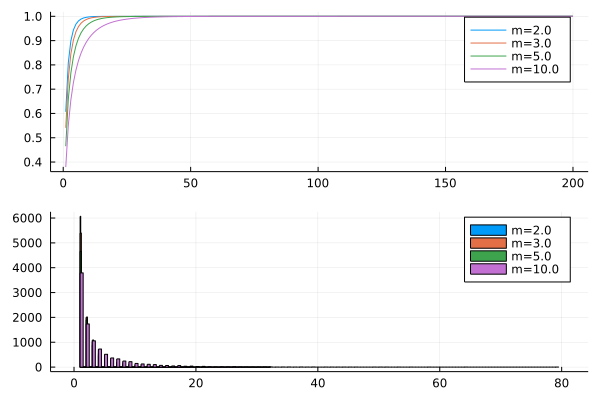

In [2]:
# PMF : probability mass function
ρ(ω,m) = ω^m/(m*log(ω+1)*(ω+1)^m)

# CDF : cumulative distribution function
function ζ(ω,M=200)
    x = zeros(M)
    cdf = 0.0
    for m in 1:M
        cdf += ρ(ω,m) 
        x[m] = cdf
    end
    return x
end

# Event size m
@inline function ξ(ω,x,M=200)
    y = rand(Uniform(0,1))
    if x[M] <= y[1] 
        m = M
    else
        for i in 1:M-1
            if x[i] >= y[1]
                m = i
                break
            else
                continue
            end
        end
    end
    return m
end;

#Plot
x1 = [ξ(2.0,ζ(2.0)) for i in 1:10000]
x2 = [ξ(3.0,ζ(3.0)) for i in 1:10000]
x3 = [ξ(5.0,ζ(5.0)) for i in 1:10000]
x4 = [ξ(10.0,ζ(10.0)) for i in 1:10000]

plt  = (plot(ζ(2.0),label="m=2.0") ; plot!(ζ(3.0),label="m=3.0") ; plot!(ζ(5.0),label="m=5.0") ; plot!(ζ(10.0),label="m=10.0"))
hist = histogram(x1,label="m=2.0") ; histogram!(x2,label="m=3.0") ; histogram!(x3,label="m=5.0") ; histogram!(x4,label="m=10.0")

plot(plt,hist,layout=(2,1))

## 2. Find solutions to non-linear equations

In [3]:
# Non-linear equations
@inline fun(t,ν0,z,τ,ω,K,Δ) = ν0*t+sum([z[i,1]*τ[i]*(1-exp(-t/τ[i])) for i in 1:K])-Δ*ω/log(ω+1)

# Find solutions to non-linear equations
@inline function nls(func, params...; ini = [0.0]) 
    if typeof(ini) <: Number
        r = nlsolve((vout,vin)->vout[1]=func(vin[1],params...), [ini])
        v = r.zero[1]
    else
        r = nlsolve((vout,vin)->vout .= func(vin,params...), ini)
        v = r.zero
    end
    return v, r.f_converged
end

nls(fun,0.01,0.99,1.0,2.0,1,rand(Exponential(1)),ini=0.0) 

(7.735220279666225, true)

## 3. Discrete superposition of exponential kernels

In [4]:
# Jump in [t,t+dt]
@inline jump(t,z,τ,n,m) = z*exp(-t/τ)+n*m/τ

# No jump during [t,t+dt]
@inline no_jump(z,τ,t) = z*exp(-t/τ)

# (T,N) = (10^8,10^8) @time : 13.038416 seconds (2 allocations: 762.939 MiB, 0.72% gc time)
function time(T,N)
    t = rand(Uniform(0.0,T),N) ; sort!(t) 
    return t
end;

# Time-rescaling theorem
function Time_Rescaling_Theorem(par,T=10^4,N=10^4)
    @unpack K,ν0,ω,n = par
    
    λt = zeros(N) 
    z  = zeros(K,2)
    tΔ = zeros(2)
    
    t = time(T,N)                
    τ = rand(Uniform(1.0,3.0),K) # The memory length τ
    n = [n/K for i in 1:K]       # The branching ratio n 
    CDF = ζ(ω)                    
   
    Δ = nls(fun,ν0,z[:,1],τ,ω,K,rand(Exponential(1)),ini=0.0)[1]
    tΔ[2] = tΔ[1] + Δ
    m = ξ(ω,CDF)
    z[:,2] = [jump(Δ,z[i,1],τ[i],n[i],m) for i in 1:K]
    for i in 1:N
        while true
            if t[i] < tΔ[2]
                δ = t[i] - tΔ[1]
                λt[i] = ν0+sum([no_jump(z[i,1],τ[i],δ) for i in 1:K])
                break
            else
                tΔ[1] = tΔ[2]
                z[:,1] = z[:,2]
                Δ = nls(fun,ν0,z[:,1],τ,ω,K,rand(Exponential(1)),ini=0.0)[1]
                tΔ[2] = tΔ[1] + Δ
                m = ξ(ω,CDF)
                z[:,2] = [jump(Δ,z[i,1],τ[i],n[i],m) for i in 1:K]
            end
        end
    end
    t,τ,n,λt
end

# Parameters
par = (
    K  = 5, 
    n  = 0.99, 
    ω  = 0.01,
    ν0 = 0.01
)

@time t,τ,n,λt = Time_Rescaling_Theorem(par)

println("・The branching ratio n = $n")
println("・The memory length τ = $τ")

# DataFrame
df = DataFrame(Time=t,Intensity=λt) 
@show describe(df.Intensity)

# Plot
plt = plot(df.Time,df.Intensity,xlabel = "Time",ylabel = "Intensity",title  = "Hawkes process",label  = "")
hist = histogram(df.Intensity,xlabel = "Intensity",ylabel = "Counts",title = "Frequency distribution",label = "")
plot(plot!(plt,x->mean(df.Intensity),label="Mean value",legendfontsize=5),hist,layout=(2,1))

  0.918617 seconds (2.74 M allocations: 144.697 MiB, 4.26% gc time, 88.52% compilation time)
・The branching ratio n = [0.198, 0.198, 0.198, 0.198, 0.198]
・The memory length τ = [1.6301976173237225, 1.5948333746201815, 2.801462379293649, 1.2158090554005263, 2.4118310309538034]
Summary Stats:
Length:         10000
Missing Count:  0
Mean:           0.713274
Minimum:        0.010000
1st Quartile:   0.010000
Median:         0.010000
3rd Quartile:   0.015202
Maximum:        36.155607
Type:           Float64
describe(df.Intensity) = nothing


## 4. Power-law memory kernel

In [5]:
# Inverse gamma distribution
## PDF
PDF_IΓ(x,γ,α=1.0) = (α^γ*exp(-α/x))/(gamma(γ)*x^(γ+1))

## CDF
CDF_IΓ(τ,γ,α=1.0) = gamma(γ,α/τ)/gamma(γ)

# Non-linear equations
CDF_IΓ_n(τ,γ,n) = CDF_IΓ(τ,γ)-n

## n,τ
function n_τ(K,n,γ)
    x = [(k-0.5)/K for k in 1:K] ; x = x/x[end]        # The branching ratio n
    τ = [nls(CDF_IΓ_n,γ,x[k],ini=0.1)[1] for k in 1:K] # The memory length τ
    n = [n/K for k in 1:K]
    return(n,τ)
end

# Time-rescaling theorem
function Time_Rescaling_Theorem(par,T=10^4,N=10^4)
    @unpack K,ν0,ω,n,γ = par
    
    λt = zeros(N) 
    z  = zeros(K,2)
    tΔ = zeros(2)
    
    t = time(T,N)
    n,τ = n_τ(K,n,γ) # n,τ
    CDF = ζ(ω)
    
    Δ = nls(fun,ν0,z[:,1],τ,ω,K,rand(Exponential(1)),ini=0.0)[1]
    tΔ[2] = tΔ[1] + Δ
    m = ξ(ω,CDF)
    z[:,2] = [jump(Δ,z[i,1],τ[i],n[i],m) for i in 1:K]
    for i in 1:N
        while true
            if t[i] < tΔ[2]
                δ = t[i] - tΔ[1]
                λt[i] = ν0+sum([no_jump(z[i,1],τ[i],δ) for i in 1:K])
                break
            else
                tΔ[1] = tΔ[2]
                z[:,1] = z[:,2]
                Δ = nls(fun,ν0,z[:,1],τ,ω,K,rand(Exponential(1)),ini=0.0)[1]
                tΔ[2] = tΔ[1] + Δ
                m = ξ(ω,CDF)
                z[:,2] = [jump(Δ,z[i,1],τ[i],n[i],m) for i in 1:K]
            end
        end
    end
    t,τ,n,λt
end

# Parameters
par = (
    K = 1000,
    ω = 0.01,
    ν0 = 0.01,
    n = 0.99,
    γ = 3.0
)

@time t,τ,n,λt = Time_Rescaling_Theorem(par)

# println("・The branching ratio n = $n")
# println("・The memory length τ = $τ")

# DataFrame
df = DataFrame(Time=t,Intensity=λt) 
@show describe(df.Intensity)

# Plot
plt = plot(df.Time,df.Intensity,xlabel = "Time",ylabel = "Intensity",title  = "Hawkes process",label  = "")
hist = histogram(df.Intensity,xlabel = "Intensity",ylabel = "Counts",title = "Frequency distribution",label = "")
plot(plot!(plt,x->mean(df.Intensity),label="Mean value",legendfontsize=5),hist,layout=(2,1))

  6.791975 seconds (59.16 M allocations: 2.923 GiB, 6.90% gc time, 21.87% compilation time)
Summary Stats:
Length:         10000
Missing Count:  0
Mean:           1.064275
Minimum:        0.010000
1st Quartile:   0.010081
Median:         0.010509
3rd Quartile:   0.011955
Maximum:        127.215904
Type:           Float64
describe(df.Intensity) = nothing
